In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_original = pd.read_parquet(f'Pairs_SP500_FPT/spx_impl_vols_new.parquet')

# Define the window size and step size of the pairs construction
YEAR = 252 # a month has approximately 252 trading days (252 samples)
window_size = 3 * YEAR  # 3 years - 756 samples
step_size = YEAR // 2  # 6 months - 126 samples 
df_original['Date'] = pd.to_datetime(df_original['Date'], format='%Y-%m-%d') # Convert column date to datetime
df_original = df_original[df_original['Date']>='2005-09-01']    # filter the df so it only mantains the desired dates (we have to take one day prior to the first to do the estimations)
df_original = df_original[~df_original['p_price'].isna()]  # Eliminate rows that have no stock prices
df_original['Id'] = df_original['Id'].str.replace('-', '_') # Change name of the columns to avoid calculation issues
series01_orig = df_original.pivot(index='Date', columns='Id', values='p_price')
series01_orig = series01_orig.sort_index()
series01_orig = series01_orig.dropna(axis=1)
df_orig = series01_orig
df_orig

Id,AAPL_US,ABT_US,ADBE_US,ADI_US,ADM_US,ADP_US,ADSK_US,AEE_US,AEP_US,AES_US,...,VMC_US,VRSN_US,VRTX_US,VZ_US,WAT_US,WBA_US,WMT_US,WYNN_US,XEL_US,ZBH_US
Date,,,,,,,,,,,,,,,,,,,,,
2005-09-01,1.652143,45.14,26.83,36.20,23.48,42.24,42.61,55.81,37.50,15.55,...,70.200000,21.67,18.33,32.62,45.74,45.75,45.00,48.85,19.51,82.10
2005-09-02,1.650714,44.88,26.64,36.57,23.71,42.47,42.59,55.86,37.72,15.42,...,70.000000,21.60,17.90,32.48,45.58,45.13,44.55,48.60,19.49,82.74
2005-09-06,1.742857,45.30,27.35,37.21,23.76,42.81,43.44,55.72,37.96,15.31,...,70.870010,22.68,18.03,32.90,46.10,45.78,45.69,49.37,19.62,83.67
2005-09-07,1.738571,45.68,27.19,36.88,23.20,42.42,43.84,55.41,38.20,15.68,...,71.020004,23.63,18.21,32.73,45.96,46.05,45.86,50.91,19.56,83.10
2005-09-08,1.777857,45.39,27.61,37.45,23.18,42.35,43.91,54.99,37.97,14.99,...,69.910000,23.05,18.04,32.48,45.36,44.89,45.86,50.47,19.21,79.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-21,192.350000,102.96,481.85,216.64,61.27,252.14,220.28,74.56,92.62,21.04,...,262.180000,174.22,442.00,39.62,351.65,16.68,65.15,96.59,56.74,119.00
2024-05-22,190.900000,104.82,483.93,240.16,61.90,254.02,219.96,73.20,91.48,20.93,...,260.870000,175.07,447.53,39.79,348.80,16.47,65.25,95.48,55.52,119.33
2024-05-23,186.880000,104.23,483.31,234.56,60.72,251.49,215.16,71.50,89.28,20.56,...,257.210000,172.00,450.80,39.43,336.79,15.95,64.84,94.09,54.05,115.85


In [3]:
df_reset = df_orig.reset_index()
df_reset['Date'] = pd.to_datetime(df_reset['Date'])
# Use pd.melt to transform the DataFrame
melted_df = pd.melt(df_reset, id_vars='Date', var_name='symbol', value_name='price')
melted_df

,Date,symbol,price
0,2005-09-01,AAPL_US,1.652143
1,2005-09-02,AAPL_US,1.650714
2,2005-09-06,AAPL_US,1.742857
3,2005-09-07,AAPL_US,1.738571
4,2005-09-08,AAPL_US,1.777857
...,...,...,...
1228522,2024-05-21,ZBH_US,119.000000
1228523,2024-05-22,ZBH_US,119.330000
1228524,2024-05-23,ZBH_US,115.850000
1228525,2024-05-24,ZBH_US,116.410000


In [4]:
dprices = pd.read_csv('20240529/daily_prices.csv', index_col=0)
dprices['symbol'] = dprices['symbol'].str.replace('-', '_')
dprices['date'] = pd.to_datetime(dprices['date'])
df = melted_df.merge(dprices[['id','date','symbol','market_cap']], how='left',left_on=['Date','symbol'],right_on=['date','symbol'])
df

/tmp/ipykernel_98504/4087286710.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  dprices = pd.read_csv('20240529/daily_prices.csv', index_col=0)


,Date,symbol,price,id,date,market_cap
0,2005-09-01,AAPL_US,1.652143,03783310,2005-09-01,38387.891597
1,2005-09-02,AAPL_US,1.650714,03783310,2005-09-02,38354.700446
2,2005-09-06,AAPL_US,1.742857,03783310,2005-09-06,40495.658493
3,2005-09-07,AAPL_US,1.738571,03783310,2005-09-07,40396.079500
4,2005-09-08,AAPL_US,1.777857,03783310,2005-09-08,41308.890169
...,...,...,...,...,...,...
1228522,2024-05-21,ZBH_US,119.000000,98956P10,2024-05-21,24481.678833
1228523,2024-05-22,ZBH_US,119.330000,98956P10,2024-05-22,24549.569580
1228524,2024-05-23,ZBH_US,115.850000,98956P10,2024-05-23,23833.634079
1228525,2024-05-24,ZBH_US,116.410000,98956P10,2024-05-24,23948.843047


In [5]:
ratios = pd.read_excel('20240529/ratios.xlsx', index_col=0)
ratios['date'] = pd.to_datetime(ratios['date'])
df = df.merge(ratios[['date','id','book_value_per_share']], how='left',left_on=['Date','id'],right_on=['date','id'])
df

,Date,symbol,price,id,date_x,market_cap,date_y,book_value_per_share
0,2005-09-01,AAPL_US,1.652143,03783310,2005-09-01,38387.891597,NaT,NaN
1,2005-09-02,AAPL_US,1.650714,03783310,2005-09-02,38354.700446,NaT,NaN
2,2005-09-06,AAPL_US,1.742857,03783310,2005-09-06,40495.658493,NaT,NaN
3,2005-09-07,AAPL_US,1.738571,03783310,2005-09-07,40396.079500,NaT,NaN
4,2005-09-08,AAPL_US,1.777857,03783310,2005-09-08,41308.890169,NaT,NaN
...,...,...,...,...,...,...,...,...
1228522,2024-05-21,ZBH_US,119.000000,98956P10,2024-05-21,24481.678833,NaT,NaN
1228523,2024-05-22,ZBH_US,119.330000,98956P10,2024-05-22,24549.569580,NaT,NaN
1228524,2024-05-23,ZBH_US,115.850000,98956P10,2024-05-23,23833.634079,NaT,NaN
1228525,2024-05-24,ZBH_US,116.410000,98956P10,2024-05-24,23948.843047,NaT,NaN


In [6]:
df['book_value_per_share'] = df.groupby('symbol')['book_value_per_share'].ffill()
df = df.drop(['date_x','date_y'],axis=1)
df.loc[:,'return'] = df.groupby('symbol')['price'].pct_change()
df = df.dropna()
df['btm'] = df['book_value_per_share']/df['price']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1183954 entries, 20 to 1228526
Data columns (total 8 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   Date                  1183954 non-null  datetime64[ms]
 1   symbol                1183954 non-null  object        
 2   price                 1183954 non-null  float64       
 3   id                    1183954 non-null  object        
 4   market_cap            1183954 non-null  float64       
 5   book_value_per_share  1183954 non-null  float64       
 6   return                1183954 non-null  float64       
 7   btm                   1183954 non-null  float64       
dtypes: datetime64[ms](1), float64(5), object(2)
memory usage: 81.3+ MB


In [7]:
df.loc[:,'size_group'] = df.groupby('Date')['market_cap'].transform(
    lambda x: pd.qcut(x, 2, labels=['Small', 'Big'])
)

# Step 2: Sort by btm_ratio within each size group and create High, Neutral, Low portfolios
def assign_btm_group(x):
    return pd.qcut(x, [0, 0.3, 0.7, 1], labels=['Low', 'Neutral', 'High'])

df.loc[:,'btm_group'] = df.groupby(['Date', 'size_group'])['btm'].transform(assign_btm_group)

# Step 3: Calculate the average return for each of the 6 portfolios
portfolios = df.groupby(['Date', 'size_group', 'btm_group'])['return'].mean().unstack(['size_group', 'btm_group'])

small = (portfolios[('Small', 'High')] + portfolios[('Small', 'Neutral')] + portfolios[('Small', 'Low')]) / 3
big = (portfolios[('Big', 'High')] + portfolios[('Big', 'Neutral')] + portfolios[('Big', 'Low')]) / 3
smb = small - big

high = (portfolios[('Small', 'High')] + portfolios[('Big', 'High')]) / 2
low = (portfolios[('Small', 'Low')] + portfolios[('Big', 'Low')]) / 2
hml = high - low

/tmp/ipykernel_98504/1794435241.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.loc[:,'btm_group'] = df.groupby(['Date', 'size_group'])['btm'].transform(assign_btm_group)
/tmp/ipykernel_98504/1794435241.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  portfolios = df.groupby(['Date', 'size_group', 'btm_group'])['return'].mean().unstack(['size_group', 'btm_group'])


In [8]:
df = df.sort_values(by=['symbol', 'Date'])

# Step 1: Calculate the cumulative returns over the past 11 months (excluding the last month)
# Define the window size: 11 months of trading days minus 1 month (approx 21 trading days)
window_size = 252 - 21

# Calculate past return over the window size, excluding the most recent month
def aux_func(x):
    a = x.shift(21)
    b = x.shift(window_size+21)
    return (a/b)-1
a = df.groupby('symbol')['price'].apply(aux_func)
df['past_return'] = a.values
# Step 2: Rank stocks based on their past return
df['momentum_rank'] = df.groupby('Date')['past_return'].transform(lambda x: x.rank(method='first'))

# Step 3: Identify Winner (Top 10%) and Loser (Bottom 10%) portfolios
df['momentum_group'] = pd.qcut(df['momentum_rank'], 10, labels=False)

# Winners: momentum_group = 9 (top 10%)
# Losers: momentum_group = 0 (bottom 10%)
winners = df[df['momentum_group'] == 9]
losers = df[df['momentum_group'] == 0]

# Calculate average returns for Winner and Loser portfolios
winners_avg_return = winners.groupby('Date')['return'].mean()
losers_avg_return = losers.groupby('Date')['return'].mean()

# Step 5: Calculate the Momentum Factor (MOM)
mom = winners_avg_return - losers_avg_return

In [15]:
df_smb = pd.DataFrame({'smb':smb})
df_hml = pd.DataFrame({'hml':hml})
df_mom = pd.DataFrame({'mom':mom})
df_factors = df_smb.merge(df_hml,how='outer',left_index=True,right_index=True).merge(df_mom,how='outer',left_index=True,right_index=True)
df_factors = df_factors.dropna()

## Analysis factors

In [16]:
import seaborn as sns

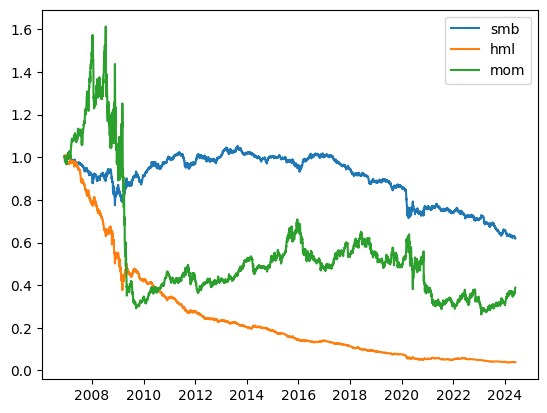

In [19]:
plt.plot(df_factors.index,(df_factors['smb']+1).cumprod())
plt.plot(df_factors.index,(df_factors['hml']+1).cumprod())
plt.plot(df_factors.index,(df_factors['mom']+1).cumprod())
plt.legend(['smb','hml','mom'])

<Axes: >

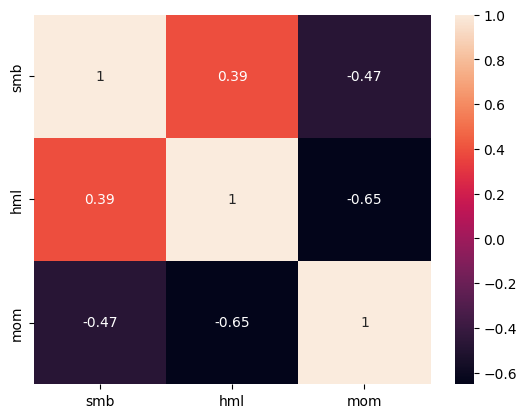

In [21]:
sns.heatmap(df_factors.corr(),annot=True)